In [1]:
import argparse
import json
import os
from pathlib import Path

import numpy as np
import torch
from PIL import Image
from typing import Dict, Any

from lib import modeling

import lib.data.transforms2d as t2d
from lib.config import config
from lib.utils.intrinsics import adjust_intrinsic
from lib.structures import DepthMap

import lib.visualize as vis
from lib.visualize import io, utils
from lib.visualize.image import write_detection_image, write_depth
from lib.structures.frustum import compute_camera2frustum_transform

import matplotlib.pyplot as plt

import platform
print(platform.python_version_tuple())
print(type(platform.python_version_tuple()))

%load_ext autoreload
%autoreload 2

('3', '8', '10')
<class 'tuple'>


### Load Model

In [4]:
input_path = "data/front3d-sample/rgb_0007.png"
config_file = "configs/front3d_sample.yaml"
model_path = "data/panoptic-front3d.pth"
output = "output/sample_0007/"
opts=None

config.OUTPUT_DIR = output
config.merge_from_file(config_file)
# config.merge_from_list(opts)
# inference settings
config.MODEL.FRUSTUM3D.IS_LEVEL_64 = False
config.MODEL.FRUSTUM3D.IS_LEVEL_128 = False
config.MODEL.FRUSTUM3D.IS_LEVEL_256 = False
config.MODEL.FRUSTUM3D.FIX = True
    
# Define model and load checkpoint.
device = torch.device("cuda:0")

print("Load model...")
model = modeling.PanopticReconstruction()
model_dict = model.state_dict()

# Remove dicts of modules whose size has been modified to avoid conflicts
checkpoint = torch.load("/usr/src/app/panoptic-reconstruction/data/panoptic-front3d.pth")
pretrained_model = checkpoint.pop("model")
pretrained_model.pop("frustum3d.model.model.encoder.0.conv1.kernel")
pretrained_model.pop("frustum3d.model.model.encoder.0.downsample.0.kernel")
pretrained_model.pop("frustum3d.model.model.decoder.0.kernel")
pretrained_model.pop("frustum3d.model.model.submodule.decoder.0.kernel")


# pretrained_dict.pop('')
# print('\n\ncheckpont: ',checkpoint.pop("model").keys())
model_dict.update(pretrained_model)
model.load_state_dict(model_dict) 

model = model.to(device)  # move to gpu
model.switch_test()

Load model...
-----------------------------------------
unet_output_channels 16
unet_fetures 16


### Load Image and apply transforms

Load input image...


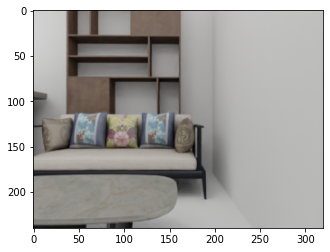

torch.Size([1, 3, 240, 320])


In [5]:
# Define image transformation.
color_image_size = (320, 240)
depth_image_size = (160, 120)

imagenet_stats = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
image_transforms = t2d.Compose([
    t2d.Resize(color_image_size),
    t2d.ToTensor(),
    t2d.Normalize(imagenet_stats[0], imagenet_stats[1]),  # use imagenet stats to normalize image
])

# Open and prepare input image.
print("Load input image...")
input_image = Image.open(input_path)
input_image_orig = input_image.copy()
plt.imshow(input_image)
plt.show()

input_image = image_transforms(input_image)
input_image = input_image.unsqueeze(0).to(device)
print(input_image.shape)

## Perform Panoptic 3D Reconstruction

In [6]:
# Prepare intrinsic matrix.
front3d_intrinsic = np.array(config.MODEL.PROJECTION.INTRINSIC)
front3d_intrinsic = adjust_intrinsic(front3d_intrinsic, color_image_size, depth_image_size)
front3d_intrinsic = torch.from_numpy(front3d_intrinsic).to(device).float()

# Prepare frustum mask.
front3d_frustum_mask = np.load(str("data/frustum_mask.npz"))["mask"]
front3d_frustum_mask = torch.from_numpy(front3d_frustum_mask).bool().to(device).unsqueeze(0).unsqueeze(0)

In [7]:
print("Perform panoptic 3D scene reconstruction...")
with torch.no_grad():
    results = model.inference(input_image, front3d_intrinsic, front3d_frustum_mask)

Perform panoptic 3D scene reconstruction...
input_img: torch.Size([1, 3, 240, 320])
======Sparse Generative Completion=======


/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/src/app/panoptic-reconstruction/lib/modeling/projection/sparse_projection.py:195: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  padding_offsets = difference // 2
/usr/local/lib/python3.8/dist-packages/MinkowskiEngine-0.5.1-py3.8-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:512: UserWarning: __floordiv__ is deprecated, and its behavior w

==========Post Process==========
geometry: torch.Size([1, 1, 256, 256, 256])
instances: torch.Size([1, 1, 256, 256, 256])
semantics: torch.Size([1, 1, 256, 256, 256])
rgb: torch.Size([1, 1, 256, 256, 256])
rgb: torch.Size([256, 256, 256])
results panoptic_instances: torch.Size([256, 256, 256])
results panoptic_semantics: torch.Size([256, 256, 256])
results frustum_geometry: torch.Size([380525, 1])


### Get all outputs

In [8]:
device = results["input"].device
depth_map: DepthMap = results["depth"]
depth_map_pcl, depthmap_coords2d = depth_map.compute_pointcloud()
depth_image = depth_map.depth_map.cpu().numpy()
depth_map_pcl_np = depth_map_pcl.cpu().numpy()

In [9]:
# Visualize projection
projection = results["projection"].C[:, 1:]

# Visualize 3D outputs
dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION
iso_value = config.MODEL.FRUSTUM3D.ISO_VALUE

geometry = results["frustum"]["geometry"]
surface, _, _ = geometry.dense(dense_dimensions, min_coordinates, default_value=truncation)
instances = results["panoptic"]["panoptic_instances"]
semantics = results["panoptic"]["panoptic_semantics"]

In [10]:
# Main outputs
camera2frustum = compute_camera2frustum_transform(depth_map.intrinsic_matrix.cpu(), torch.tensor(results["input"].size()) / 2.0,
                                                      config.MODEL.PROJECTION.DEPTH_MIN,
                                                      config.MODEL.PROJECTION.DEPTH_MAX,
                                                      config.MODEL.PROJECTION.VOXEL_SIZE)

# remove padding: original grid size: [256, 256, 256] -> [231, 174, 187]
camera2frustum[:3, 3] += (torch.tensor([256, 256, 256]) - torch.tensor([231, 174, 187])) / 2
frustum2camera = torch.inverse(camera2frustum)
print(frustum2camera)

tensor([[ 0.0300,  0.0000,  0.0000, -3.8175],
        [ 0.0000,  0.0300,  0.0000, -3.8064],
        [ 0.0000,  0.0000,  0.0300, -0.6350],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


## Get Voxelized representation of meshes

In [12]:
# Meshes (SDF)
from typing import Union, Tuple, Optional
import marching_cubes as mc
from lib.utils.transform import coords_multiplication


def get_mesh(distance_field: np.array, iso_value: float = 1.0, truncation: float = 3.0) -> Tuple[np.array, np.array]:
    vertices, triangles = mc.marching_cubes(distance_field, iso_value, truncation)
    return vertices, triangles


def get_mesh_with_semantics(distance_field: np.array, labels: np.array, iso_value: float = 1.0, truncation: float = 3.0,
                            color_palette=None) -> Tuple[np.array, np.array, np.array]:
    labels = labels.astype(np.uint32)
    color_volume = utils.lookup_colors(labels, color_palette)
    print("color_volume: {}".format(color_volume.shape))
    vertices, colors, triangles = get_mesh_with_colors(distance_field, color_volume, iso_value, truncation)

    return vertices, colors, triangles

def get_mesh_with_colors(distance_field: np.array, colors: np.array, iso_value: float = 1.0,
                         truncation: float = 3.0) -> Tuple[np.array, np.array, np.array]:
    print("distance_field shape: {}".format(distance_field.shape))
    print("colors shape: {}".format(colors.shape))
    vertices, triangles = mc.marching_cubes_color(distance_field, colors, iso_value, truncation)
    colors = vertices[..., 3:]
    vertices = vertices[..., :3]

    return vertices, colors, triangles

def write_distance_field2(distance_field: Union[np.array, torch.Tensor], labels: Optional[Union[np.array, torch.Tensor]], iso_value: float = 1.0, truncation: float = 3.0,
                         color_palette=None, transform=None) -> None:
    if isinstance(distance_field, torch.Tensor):
        distance_field = distance_field.detach().cpu().numpy()

    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    if labels is not None:
        vertices, colors, triangles = get_mesh_with_semantics(distance_field, labels, iso_value, truncation,
                                                              color_palette)
    else:
        vertices, triangles = get_mesh(distance_field, iso_value, truncation)
        colors = None

    if transform is not None:
        if isinstance(transform, torch.Tensor):
            transform = transform.detach().cpu().numpy()

        vertices = coords_multiplication(transform, vertices)
    return vertices, colors, triangles
    # io.write_ply(vertices, colors, triangles, output_file)
    
# print(instances.squeeze().shape)
panoptic_semantic_mapping = results["panoptic"]["panoptic_semantic_mapping"]
instances = results["panoptic"]["panoptic_instances"]

vertices, colors, triangles = write_distance_field2(surface.squeeze(), None, transform=frustum2camera)
vertices_i, colors_i, triangles_i = write_distance_field2(surface.squeeze(), instances.squeeze(), transform=frustum2camera)
vertices_s, colors_s, triangles_s = write_distance_field2(surface.squeeze(), semantics.squeeze(), transform=frustum2camera)
print("SHAPES: vertices:{}, colors:{}, triangles: {}".format(vertices.shape, 0, triangles.shape))
print("SHAPES instance: vertices:{}, colors:{}, triangles: {}".format(vertices_i.shape, colors_i.shape, triangles_i.shape))
print("SHAPES semantic: vertices:{}, colors:{}, triangles: {}".format(vertices_s.shape, colors_s.shape, triangles_s.shape))

color_volume: (256, 256, 256, 3)
distance_field shape: (256, 256, 256)
colors shape: (256, 256, 256, 3)
color_volume: (256, 256, 256, 3)
distance_field shape: (256, 256, 256)
colors shape: (256, 256, 256, 3)
SHAPES: vertices:(169980, 3), colors:0, triangles: (338240, 3)
SHAPES instance: vertices:(169980, 3), colors:(169980, 3), triangles: (338240, 3)
SHAPES semantic: vertices:(169980, 3), colors:(169980, 3), triangles: (338240, 3)


## Use Pytorch3d To Render different views

In [10]:
import os
import sys
import torch
import pytorch3d
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import Textures

from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex,
    OpenGLPerspectiveCameras, 
    
)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


vertices = torch.from_numpy(vertices_i.astype(np.float32))
triangles = torch.from_numpy(triangles_i.astype(np.int64))

### Obtain rgb color values for each vertex

In [11]:
# input_img = results["input"]
from torchvision import transforms
image_transforms = t2d.Compose([
    t2d.ToTensor(),
    transforms.Scale((120,160))
])
input_img = image_transforms(input_image_orig)
input_img = input_img.view(3,-1)
print(input_img.max())
print(input_img.min())

print("input_img: {}".format(input_img.shape))


# RGB PCL
# color_pcl = input_img[0, :, depth_pixels_xy[:, 0], depth_pixels_xy[:, 1]]
color_pcl = input_img.permute(1, 0)
print("color_pcl: {}".format(color_pcl.shape))

colors_rgb = torch.zeros_like(vertices).cuda()
print("colors_rgb: {}".format(colors_rgb.shape))


# Match vertices with pcl
print("vertices: {}".format(vertices.shape))
print("depth_map_pcl: {}".format(depth_map_pcl.shape))
sim = torch.cdist(vertices.cpu(), depth_map_pcl.cpu())
print("sim: {}".format(sim.shape))
idxs = torch.argmin(sim, 1, keepdim=False)

for i, idx in enumerate(idxs):
    colors_rgb[i,:] = color_pcl[idx,:]
# colors_rgb = color_pcl[idxs,:]
    
    
colors_rgb = colors_rgb.unsqueeze(0)
print("colors_rgb: {}".format(colors_rgb.shape))

tensor(0.8265)
tensor(0.0245)
input_img: torch.Size([3, 19200])
color_pcl: torch.Size([19200, 3])


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


colors_rgb: torch.Size([51660, 3])
vertices: torch.Size([51660, 3])
depth_map_pcl: torch.Size([19200, 3])
sim: torch.Size([51660, 19200])
colors_rgb: torch.Size([1, 51660, 3])


### Create texture from vertex colors and create mesh

In [19]:
instance_colors = (torch.from_numpy(np.array([colors_i])).to(device)/255.0).type(torch.FloatTensor)
print(instance_colors.shape)
tex = Textures(verts_rgb=instance_colors)
mesh = Meshes(verts=[vertices], faces=[triangles], textures=tex).to(device)

torch.Size([1, 51660, 3])


In [20]:
# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

### Single View

In [21]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.0, 10, 150.0) 
print(T)
R0 = look_at_rotation(T, at=((0, 0, 3.0), ), up=((0, -1, 0), ))
print(R)
# pytorch3d.renderer.cameras.look_at_rotation(camera_position, at=((0, 0, 0), ), up=((0, 1, 0), ),
cameras = FoVPerspectiveCameras(device=device, R=R0@R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

tensor([[-0., -0., 2.]])
tensor([[[ 0.8660, -0.0868, -0.4924],
         [-0.0000,  0.9848, -0.1736],
         [ 0.5000,  0.1504,  0.8529]]])


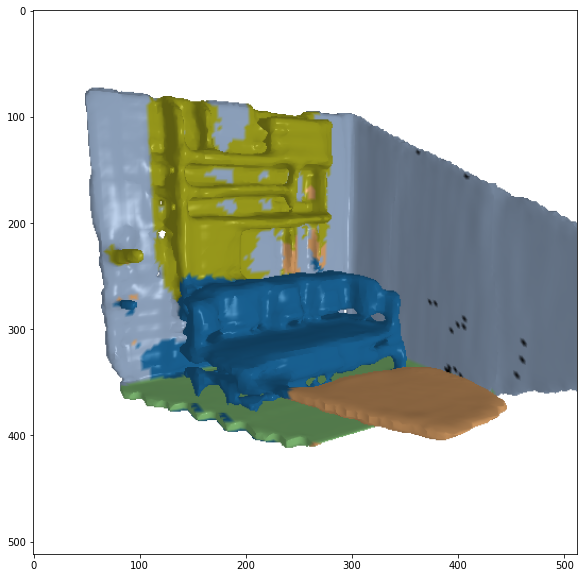

In [22]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
# plt.axis("off");

### Multiple Views

In [23]:
from plot_image_grid import image_grid
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles. 
elev = torch.linspace(140, 190, num_views)
azim = torch.linspace(-40, 40, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=1.0, elev=elev, azim=azim)
R0 = look_at_rotation(T, at=((0, 0, 3.0), ), up=((0, -1, 0), ))

cameras = OpenGLPerspectiveCameras(device=device, R=R0@R, T=T)


# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=128, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

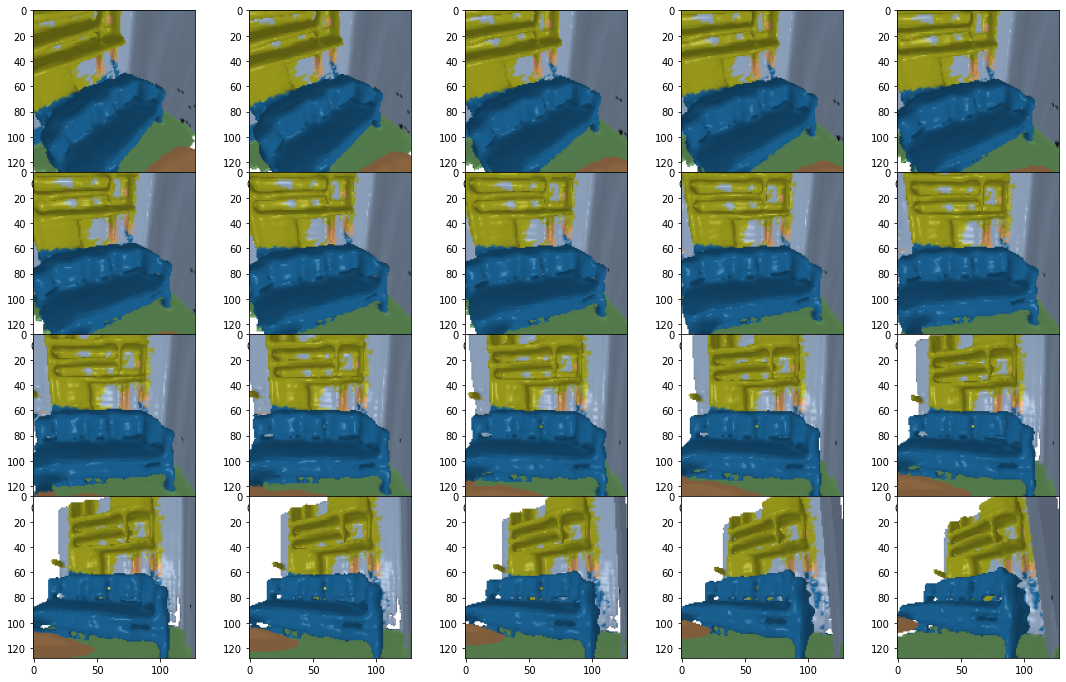

In [24]:
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True, show_axes=True)
plt.show()

In [18]:
# from lib.modeling import backbone, depth, detector, projection, frustum
# from lib.structures.field_list import FieldList
# from torch.nn import functional as F
# import MinkowskiEngine as Me

# image_size = (160, 120)
# depth_min = 0.4
# depth_max = 6.0
# frustum_dimensions = torch.tensor([256, 256, 256])

# print(results["depth"].intrinsic_matrix)
# depth = results["depth"].depth_map # In inference it is of shape torch.Size([1, 1, 120, 160])
# data = FieldList(depth.shape[0:])
# data.add_field("depth", DepthMap(depth, results["depth"].intrinsic_matrix))
# # projection.forward(depth, features, instances, [data])

# intrinsic = data.get_field("depth").intrinsic_matrix #unnecesary
# camera2frustum = compute_camera2frustum_transform(intrinsic.cpu(), (160, 120), 0.4,
#                                                               6.0, 0.03) # unnecesary
# camera2frustum = camera2frustum.to(device)
# intrinsic = intrinsic.to(device)
# intrinsic_inverse = torch.inverse(intrinsic)

# depth_pixels_xy = depth.nonzero(as_tuple=False)
# if depth_pixels_xy.shape[0] == 0:
#     print("continue")
    
# depth_pixels_z = depth[depth_pixels_xy[:, 0], depth_pixels_xy[:, 1]].reshape(-1)


# yv = depth_pixels_xy[:, 0].reshape(-1).float() * depth_pixels_z.float()
# xv = depth_pixels_xy[:, 1].reshape(-1).float() * depth_pixels_z.float()

# depth_pixels = torch.stack([xv, yv, depth_pixels_z.float(), torch.ones_like(depth_pixels_z).float()])
# pointcloud = torch.mm(intrinsic_inverse, depth_pixels.float())
# grid_coordinates = torch.mm(camera2frustum, pointcloud).t()[:, :3].contiguous()
# print("depth_pixels: {}".format(depth_pixels.shape))
# print("pointcloud: {}".format(pointcloud.shape))
# print("grid_coordinates: {}".format(grid_coordinates.shape))


# ## Projective sdf encoding
# truncation = 3.0
# num_repetition = int(truncation * 2) + 1
# grid_coordinates = grid_coordinates.unsqueeze(1).repeat(1, num_repetition, 1)
# voxel_offsets = torch.arange(-truncation, truncation + 1, 1.0, device=device).view(1, -1, 1)
# coordinates_z = grid_coordinates[:, :, 2].clone()
# grid_coordinates[:, :, 2] += voxel_offsets[:, :, 0]
# print("grid_coordinates: {}".format(grid_coordinates.shape))

# num_points = grid_coordinates.size(0)
# if num_points == 0:
#     print("continue")
    
# df_values = coordinates_z - coordinates_z.int()
# df_values = df_values + voxel_offsets.squeeze(-1)
# df_values.unsqueeze_(-1)
# print("df_values: {}".format(df_values.shape))


# # encode sign and values in 2 different channels
# sign_channel=True
# if sign_channel:
#     sign = torch.sign(df_values)
#     value = torch.abs(df_values)
#     df_values = torch.cat([sign, value], dim=-1)
# sample_features = []
# sparse_coordinates = []
# sparse_features = []

# # ======== Features
# features = torch.ones((1, 80, 120, 160)).cuda()
# image_features = features[0, :, depth_pixels_xy[:, 0], depth_pixels_xy[:, 1]]
# image_features = image_features.permute(1, 0)
# sample_features.append(image_features)

# print("image_features: {}".format(image_features.shape))

# # ====== instance features
# instances = results["instance"]
# mask_logits = instances["raw"]  # use mask logits
# locations = instances["locations"]
# start_channel = 1
# instance2d_max = 14
# num_instance_features = start_channel + instance2d_max
# mask = mask_logits[0]
# location = locations[0].long()
# if mask.dim() == 2:
#     mask = mask.unsqueeze(0)

# instance_tensor = torch.zeros((1, num_instance_features, 120, 160))
# label_mask = torch.zeros(120, 160)
# sample_labels2d = [0]

# # place instance features at correct index in 3d grid
# for instance_index, position in enumerate(location):
#     if len(mask) > 0 and instance_index < len(mask) and instance_index < num_instance_features and position < num_instance_features:
#         resized_mask = F.interpolate(input=mask[instance_index].unsqueeze(0).unsqueeze(0).float(), size=(120, 160), mode="nearest").squeeze(0).squeeze(0)
#         instance_tensor[0, position + start_channel] = resized_mask
#         label_mask += resized_mask
#         sample_labels2d.append(position + start_channel)

# instance_tensor[0, 0, label_mask == 0] = 1.0  # set freespace softmax label
# instance_tensor = instance_tensor.to(device)
# instance_features = instance_tensor[0, :, depth_pixels_xy[:, 0], depth_pixels_xy[:, 1]]
# instance_features = instance_features.permute(1, 0)
# sample_features.append(instance_features)
# print("instance_features: {}".format(instance_features.shape))
# print("instance_tensor: {}".format(instance_tensor.shape))


# if sample_features:
#     sample_features = torch.cat(sample_features, dim=-1)
#     sample_features = sample_features.unsqueeze(1).repeat(1, num_repetition, 1)
#     sample_features = torch.cat([df_values, sample_features], dim=-1)
# else:
#     sample_features = df_values

# # flatten repeated coordinates and features
# flatten_coordinates = grid_coordinates.view(num_points * num_repetition, 3)

# # pad to 256,256,256
# padding_offsets = compute_frustum_padding(intrinsic_inverse)
# flatten_coordinates = flatten_coordinates + padding_offsets #- torch.tensor([1, 1, 1]).float().to(device)  # Fix wrong voxel offset

# flat_features = sample_features.view(num_points * num_repetition, -1)

# print("flatten_coordinates: {}".format(flatten_coordinates.shape))
# print("flat_features: {}".format(flat_features.shape))

# sparse_coordinates.append(flatten_coordinates)
# sparse_features.append(flat_features)


# sparse_features = torch.cat(sparse_features, dim=0)
# batched_coordinates = Me.utils.batched_coordinates(sparse_coordinates).to(device)
# tensor = Me.SparseTensor(features=sparse_features,
#                                 coordinates=batched_coordinates,
#                                  quantization_mode=Me.SparseTensorQuantizationMode.RANDOM_SUBSAMPLE)
# print(tensor.shape)
# print(batched_coordinates.shape)
# print(sparse_features.shape)

# # print(front3d_frustum_mask)

# # self.projection: nn.Module = projection.SparseProjection()
# # self.projection(results["depth"]["prediction"], feature2d, instance_results, targets)
# # data = FieldList(depth.shape[2:])
